<a href="https://colab.research.google.com/github/AlexandreCandidoXavier/BR-DWGD/blob/main/notebooks/exemplo_google_earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com dados pontuais no Google Earth
Neste exemplo, para obtenção dos dados de um ponto,
não será necessário baixar os arquivos Netcdf. Estes serão adquiridos via a 
plataforma [Google Earth Engine](https://earthengine.google.com/), disponibilizados
em [awesome-gee-community-catalog](https://gee-community-catalog.org/projects/br_dwgd/).

Vamos trabalhar com a variável precipitação para uma posição geográfica, 
nos níveis de tempo: diário, mensal e anual.

Para rodar será necessário fazer uma cópia no seu computador ou no seu 
Google Drive, se estiver utilizando o **Colab**. Menu File -> Save copy in Drive.

In [10]:
# instalando geemap atualizado (https://geemap.org/)
# se estiver no jupyterlab rodar: %pip install -U "geemap[workshop]" -q

In [2]:
import ee
import geemap
import numpy as np
import datetime
import pandas as pd
import plotly.express as px

In [3]:
# vai pedir a autentificação (tem que ter conta gmail)
m = geemap.Map()

Pegando variável precipitação e reescalonando. Para as demais ver: https://gee-community-catalog.org/projects/br_dwgd/

In [18]:
var = ee.ImageCollection("projects/sat-io/open-datasets/BR-DWGD/PR")

# para reescalonar
offset = 225
scale  = 0.006866665

# reescalonando
def scaleBand(image):
    scaledImage = image.select("b1").rename(['pr']).multiply(scale).add(offset)
    return scaledImage.copyProperties(image, image.propertyNames())

var = var.map(scaleBand)
color_pal = ['000066', '001199', '0044BB', '0077DD', '33AAEE', '66CCFF', 'FFDDCC', 'FFBB99', 'FF9966', 'FF6644']
vis = {'min': 0,'max': 70, 'palette': color_pal}

# definindo período (tem limite)
start_date, end_date = '1961-01-01','2023-01-01' #'2010-01-01','2023-01-01'
var = var.filterDate(start_date, end_date).select(['pr']);
m.addLayer(var.first(), vis, 'Precipitação')

Definindo coordenada de onde se quer obter os dados

In [19]:
# coordenada do ponto de interesse [lon, lat]
lon_lat = [-43.04, -14.33]
point = {'type':'Point', 'coordinates': lon_lat}
m.addLayer(ee.Feature(point), {'color': 'red'}, "posição")

In [20]:
# plotando a precipitação da data inicial
m.centerObject(var)
m

Map(bottom=2409.0, center=[-14.252193310147522, -54.35002338084658], controls=(WidgetControl(options=['positio…

Pegando informações para uma posição. Pode demorar um pouco se o intervalo de tempo for grande.

In [21]:
info_point = var.getRegion(point, 500).getInfo()

## Plotando dados diários para o período

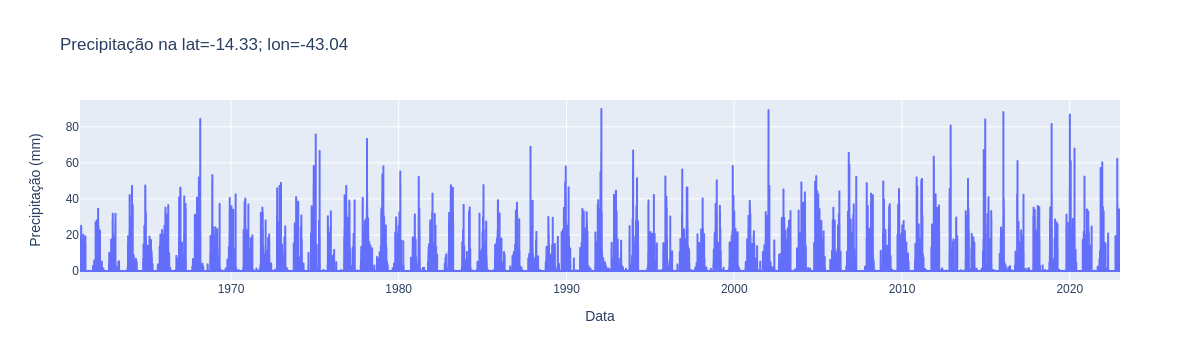

In [22]:
# organizando as datas
header = info_point[0]
data = np.array(info_point[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# criando dataframe
prec = data[:,-1].astype('float')
# prec[prec<0] = 0 # necessário pois no reescalonamento há pricipitaões menors que zero (-1.2055e-05)
df = pd.DataFrame(prec, columns=['Precipitação (mm)'])
df.set_index(np.array(time), inplace=True)
df.index.name='Data'

# plotando
fig = px.line(df, x=df.index, 
              y='Precipitação (mm)',
              title=f"Precipitação na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br> prec: %{y:.1f} mm ")
fig.show()

Para salvar dados em formato "csv"

In [23]:
# df.to_csv('dados.csv')

## Agregando dados diários para mensal e plotando

In [24]:
df_mes = df.resample('M').sum()
df_mes

,Precipitação (mm)
Data,
1960-12-31,7.010853
1961-01-31,282.782624
1961-02-28,14.577592
1961-03-31,82.880273
1961-04-30,57.164624
...,...
2022-08-31,-0.000374
2022-09-30,19.363634
2022-10-31,14.309756


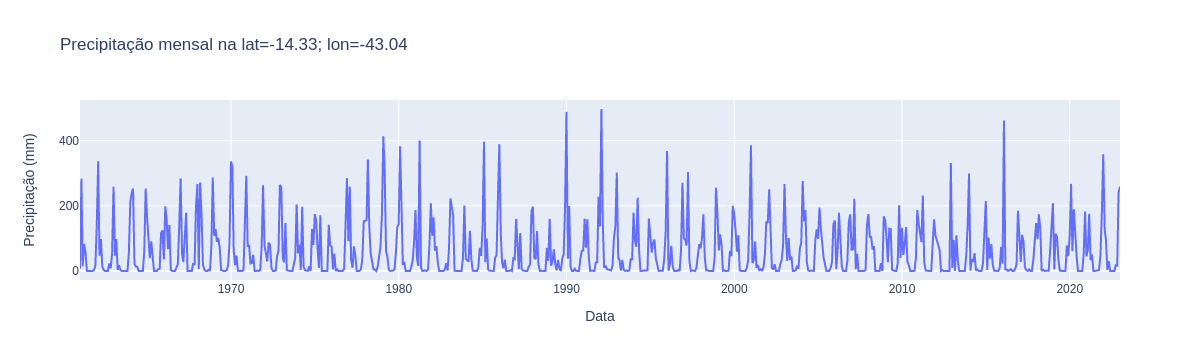

In [25]:
# Plotando mensal
fig = px.line(df_mes, x=df_mes.index, 
              y='Precipitação (mm)',
              title=f"Precipitação mensal na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.1f} mm")
fig.show()

## Agregando dados diários para anual e plotando

In [26]:
df_ano = df.resample('Y').sum()
df_ano

,Precipitação (mm)
Data,
1960-12-31,7.010853
1961-12-31,595.822989
1962-12-31,842.219529
1963-12-31,437.944627
1964-12-31,1019.448140
...,...
2018-12-31,803.642605
2019-12-31,488.929615
2020-12-31,941.820493


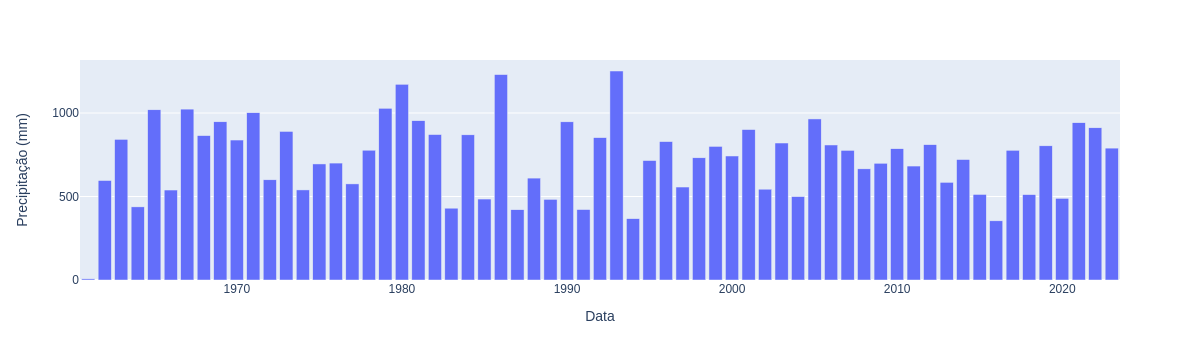

In [27]:
# plotando anual
fig = px.bar(df_ano, x=df_ano.index, y='Precipitação (mm)')
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.0f} mm")
fig.show()